<a href="https://colab.research.google.com/github/Taaniya/pose-estimation/blob/main/Explore_pose_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install openpifpaf

     |████████████████████████████████| 225kB 9.0MB/s 
     |████████████████████████████████| 71kB 6.8MB/s 
     |████████████████████████████████| 1.4MB 13.1MB/s 
  Created wheel for openpifpaf: filename=openpifpaf-0.11.9-cp36-cp36m-linux_x86_64.whl size=448346 sha256=1fb03cb41ad9235134cd3c3d68fe1aa632bdd11038c6238d3a2fccf746b6d304
  Stored in directory: /root/.cache/pip/wheels/51/21/37/a141d8ea5de10b723e8f5db1dc4e2c8085ac7db44f4ef9a1b6
  Created wheel for python-json-logger: filename=python_json_logger-2.0.1-cp36-none-any.whl size=7374 sha256=543be39d6fff696e4d814e44372d341e7a72aa7ef072fe5ed3ee72189ddaaae9
  Stored in directory: /root/.cache/pip/wheels/59/fe/d0/53a8a9f614e3d7b7b8025fac655abd7a8bf86e0980c9956030
Successfully built openpifpaf python-json-logger


In [ ]:
%matplotlib inline

import io
import numpy as np
import openpifpaf
import PIL
import requests
import torch

device = torch.device('cpu')
# device = torch.device('cuda')  # if cuda is available

print(openpifpaf.__version__)
print(torch.__version__)

0.11.9
1.7.0+cu101


(480, 640, 3)


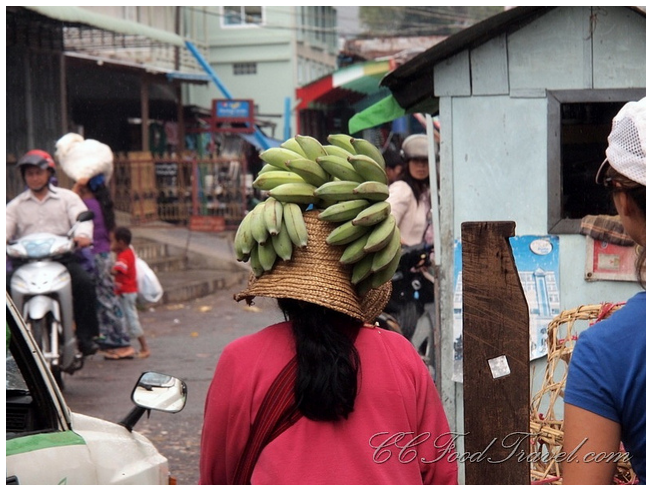

In [ ]:
image_response = requests.get('https://raw.githubusercontent.com/vita-epfl/openpifpaf/master/docs/coco/000000081988.jpg')
# pil_im = PIL.Image.open(io.BytesIO(image_response.content)).convert('RGB')

# Load own image
pil_im = PIL.Image.open("/content/000000147740.jpg")
im = np.asarray(pil_im)
print(im.shape)
with openpifpaf.show.image_canvas(im) as ax:
  pass

In [ ]:
# Loading trained model
net_cpu, test = openpifpaf.network.factory(checkpoint='shufflenetv2k16w', download_progress=False)

# Load model from system
# checkpoint = torch.load("/content/shufflenetv2k16w-200510-221334-cif-caf-caf25-o10s-604c5956.pkl", map_location=torch.device('cpu'))
# net_cpu = checkpoint['model']
# net_cpu.eval()
net = net_cpu.to(device)

openpifpaf.decoder.CifSeeds.threshold = 0.5
openpifpaf.decoder.nms.Keypoints.keypoint_threshold = 0.2
openpifpaf.decoder.nms.Keypoints.instance_threshold = 0.2
processor = openpifpaf.decoder.factory_decode(net.head_nets, basenet_stride=net.base_net.stride)

In [ ]:
type(net_cpu), type(checkpoint)

(openpifpaf.network.nets.Shell, dict)

In [ ]:
checkpoint.keys()

dict_keys(['model', 'epoch', 'meta'])

In [ ]:
checkpoint['model']

Shell(
  (base_net): BaseNetwork(
    (net): ShuffleNetV2K(
      (conv1): Sequential(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.0001, momentum=0.01, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (stage2): Sequential(
        (0): InvertedResidualK(
          (branch1): Sequential(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
            (1): BatchNorm2d(24, eps=0.0001, momentum=0.01, affine=True, track_running_stats=True)
            (2): Conv2d(24, 174, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (3): BatchNorm2d(174, eps=0.0001, momentum=0.01, affine=True, track_running_stats=True)
            (4): ReLU(inplace=True)
          )
          (branch2): Sequential(
            (0): Conv2d(24, 174, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(174, eps=0.0001, mom

In [ ]:
# Preprocessing dataset

preprocess = openpifpaf.transforms.Compose([
  openpifpaf.transforms.NormalizeAnnotations(),
  openpifpaf.transforms.CenterPadTight(16),
  openpifpaf.transforms.EVAL_TRANSFORM,
])
data = openpifpaf.datasets.PilImageList([pil_im], preprocess=preprocess)

In [ ]:
# Data loader, Visualizer

loader = torch.utils.data.DataLoader(
  data, batch_size=1, pin_memory=True, 
  collate_fn=openpifpaf.datasets.collate_images_anns_meta)

keypoint_painter = openpifpaf.show.KeypointPainter(color_connections=True, linewidth=6)

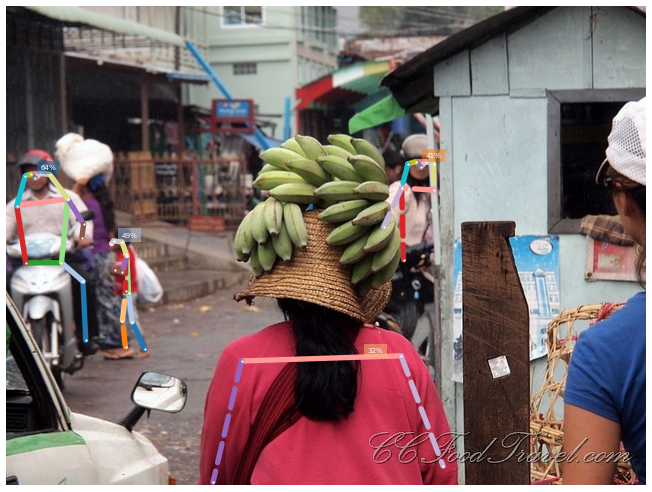

In [ ]:
# Prediction
for images_batch, _, __ in loader:
  predictions = processor.batch(net, images_batch, device=device)[0]
  with openpifpaf.show.image_canvas(im) as ax:
    keypoint_painter.annotations(ax, predictions)

#### References

* openpifpaf git repo - https://github.com/openpifpaf/openpifpaf
* paper - https://arxiv.org/pdf/2103.02440.pdf